In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
! nvidia-smi

Tue Aug  2 16:44:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 73%   83C    P2   168W / 260W |   5747MiB / 11019MiB |     88%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 32%   

# MongoDB

In [4]:
from pymongo import MongoClient
import pymongo

In [5]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_rm_us = db.rm_patent_us
    # db_rm_cn = db.rm_patent_cn
    # db_rm_de = db.rm_patent_de
    
    # db_rm_us_2020 = db.rm_patent_us_2020
    db_rm_cn_2020 = db.rm_patent_cn_2020
    # db_rm_de_2020 = db.rm_patent_de_2020
except errors.ConnectionFailure as err:
    print(err)

# 2020

## Company數量

In [6]:
data_assignee = db_rm_cn_2020.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_cn = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [7]:
# 取總數前15家公司
# final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
df_family_cn.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(16)

,company,count
17,Huawei Technologies Co Ltd,339
3,Apple Inc,144
24,Shanghai Langbo Communication Technology Co Ltd,124
23,Samsung Electronics Co Ltd,106
18,Intel Corp,86
10,China United Network Communications Group Co Ltd,70
8,China Mobile Communications Group Co Ltd,62
26,State Grid Corp of China SGCC,60
19,LG Electronics Inc,54
5,Beijing Sankuai Online Technology Co Ltd,51


In [8]:
# com_df = final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_df = df_family_cn.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_df.reset_index(drop=True, inplace=True)

In [9]:
com_df["count_log"] = com_df["count"].apply(lambda x: np.log(x))
com_df

,company,count,count_log
0,Huawei Technologies Co Ltd,339,5.826000
1,Apple Inc,144,4.969813
2,Shanghai Langbo Communication Technology Co Ltd,124,4.820282
3,Samsung Electronics Co Ltd,106,4.663439
4,Intel Corp,86,4.454347
5,China United Network Communications Group Co Ltd,70,4.248495
6,China Mobile Communications Group Co Ltd,62,4.127134
7,State Grid Corp of China SGCC,60,4.094345
8,LG Electronics Inc,54,3.988984
9,Beijing Sankuai Online Technology Co Ltd,51,3.931826


In [10]:
com_ls = list(com_df.company)

## Data

In [11]:
ccontry = pd.read_csv("../patent/code/依年分/rm_company_country_cn_2020.csv")
ccpc = pd.read_csv("../LDA/company_lda_brief_cn_2020.csv")

In [12]:
ccontry[ccontry.company.isin(com_ls)]

,company,AR,AU,BR,CA,CH,CN,CO,DE,DK,...,FR,GB,IL,JP,KR,MA,RU,SG,TW,US
27,Alipay Hangzhou Information Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,41.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91,Apple Inc,0.0,0.0,0.0,0.0,0.0,140.0,0.0,3.0,0.0,...,0.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,4.0
244,Beijing Sankuai Online Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,53.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284,Beijing Xiaomi Mobile Software Co Ltd,0.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
494,China Mobile Communications Group Co Ltd,0.0,0.0,0.0,0.0,0.0,119.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
502,China Mobile IoT Co Ltd,0.0,0.0,0.0,0.0,0.0,87.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
526,China United Network Communications Group Co Ltd,0.0,0.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1271,Huawei Technologies Co Ltd,0.0,0.0,0.0,1.0,0.0,338.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
1390,Intel Corp,0.0,2.0,3.0,0.0,0.0,86.0,0.0,39.0,0.0,...,0.0,0.0,0.0,13.0,19.0,0.0,0.0,2.0,6.0,60.0
1603,LG Electronics Inc,0.0,0.0,0.0,0.0,0.0,50.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,1.0


## Similarity計算

### Country

- 換成機率  

In [13]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

### PBC
- 和Samsung Electronics Co Ltd比較

In [14]:
ccontry_pbc = ccontry2.loc[com_ls,:].copy()
ccontry_pbc.head()

,AR,AU,BR,CA,CH,CN,CO,DE,DK,EP,FR,GB,IL,JP,KR,MA,RU,SG,TW,US
company,,,,,,,,,,,,,,,,,,,,
Huawei Technologies Co Ltd,0.0,0.000000,0.000000,0.002849,0.0,0.962963,0.0,0.000000,0.0,0.017094,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.017094
Apple Inc,0.0,0.000000,0.000000,0.000000,0.0,0.714286,0.0,0.015306,0.0,0.117347,0.0,0.005102,0.0,0.000000,0.127551,0.0,0.0,0.000000,0.000000,0.020408
Shanghai Langbo Communication Technology Co Ltd,0.0,0.000000,0.000000,0.000000,0.0,0.932331,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.067669
Samsung Electronics Co Ltd,0.0,0.000000,0.000000,0.000000,0.0,0.328804,0.0,0.021739,0.0,0.179348,0.0,0.002717,0.0,0.016304,0.222826,0.0,0.0,0.005435,0.005435,0.217391
Intel Corp,0.0,0.008163,0.012245,0.000000,0.0,0.351020,0.0,0.159184,0.0,0.061224,0.0,0.000000,0.0,0.053061,0.077551,0.0,0.0,0.008163,0.024490,0.244898


In [15]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

### CPC

In [16]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [17]:
ccpc_pbc = ccpc2.loc[com_ls,:].copy()
# ccpc_pbc

In [18]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

## Scatter Plot

In [19]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

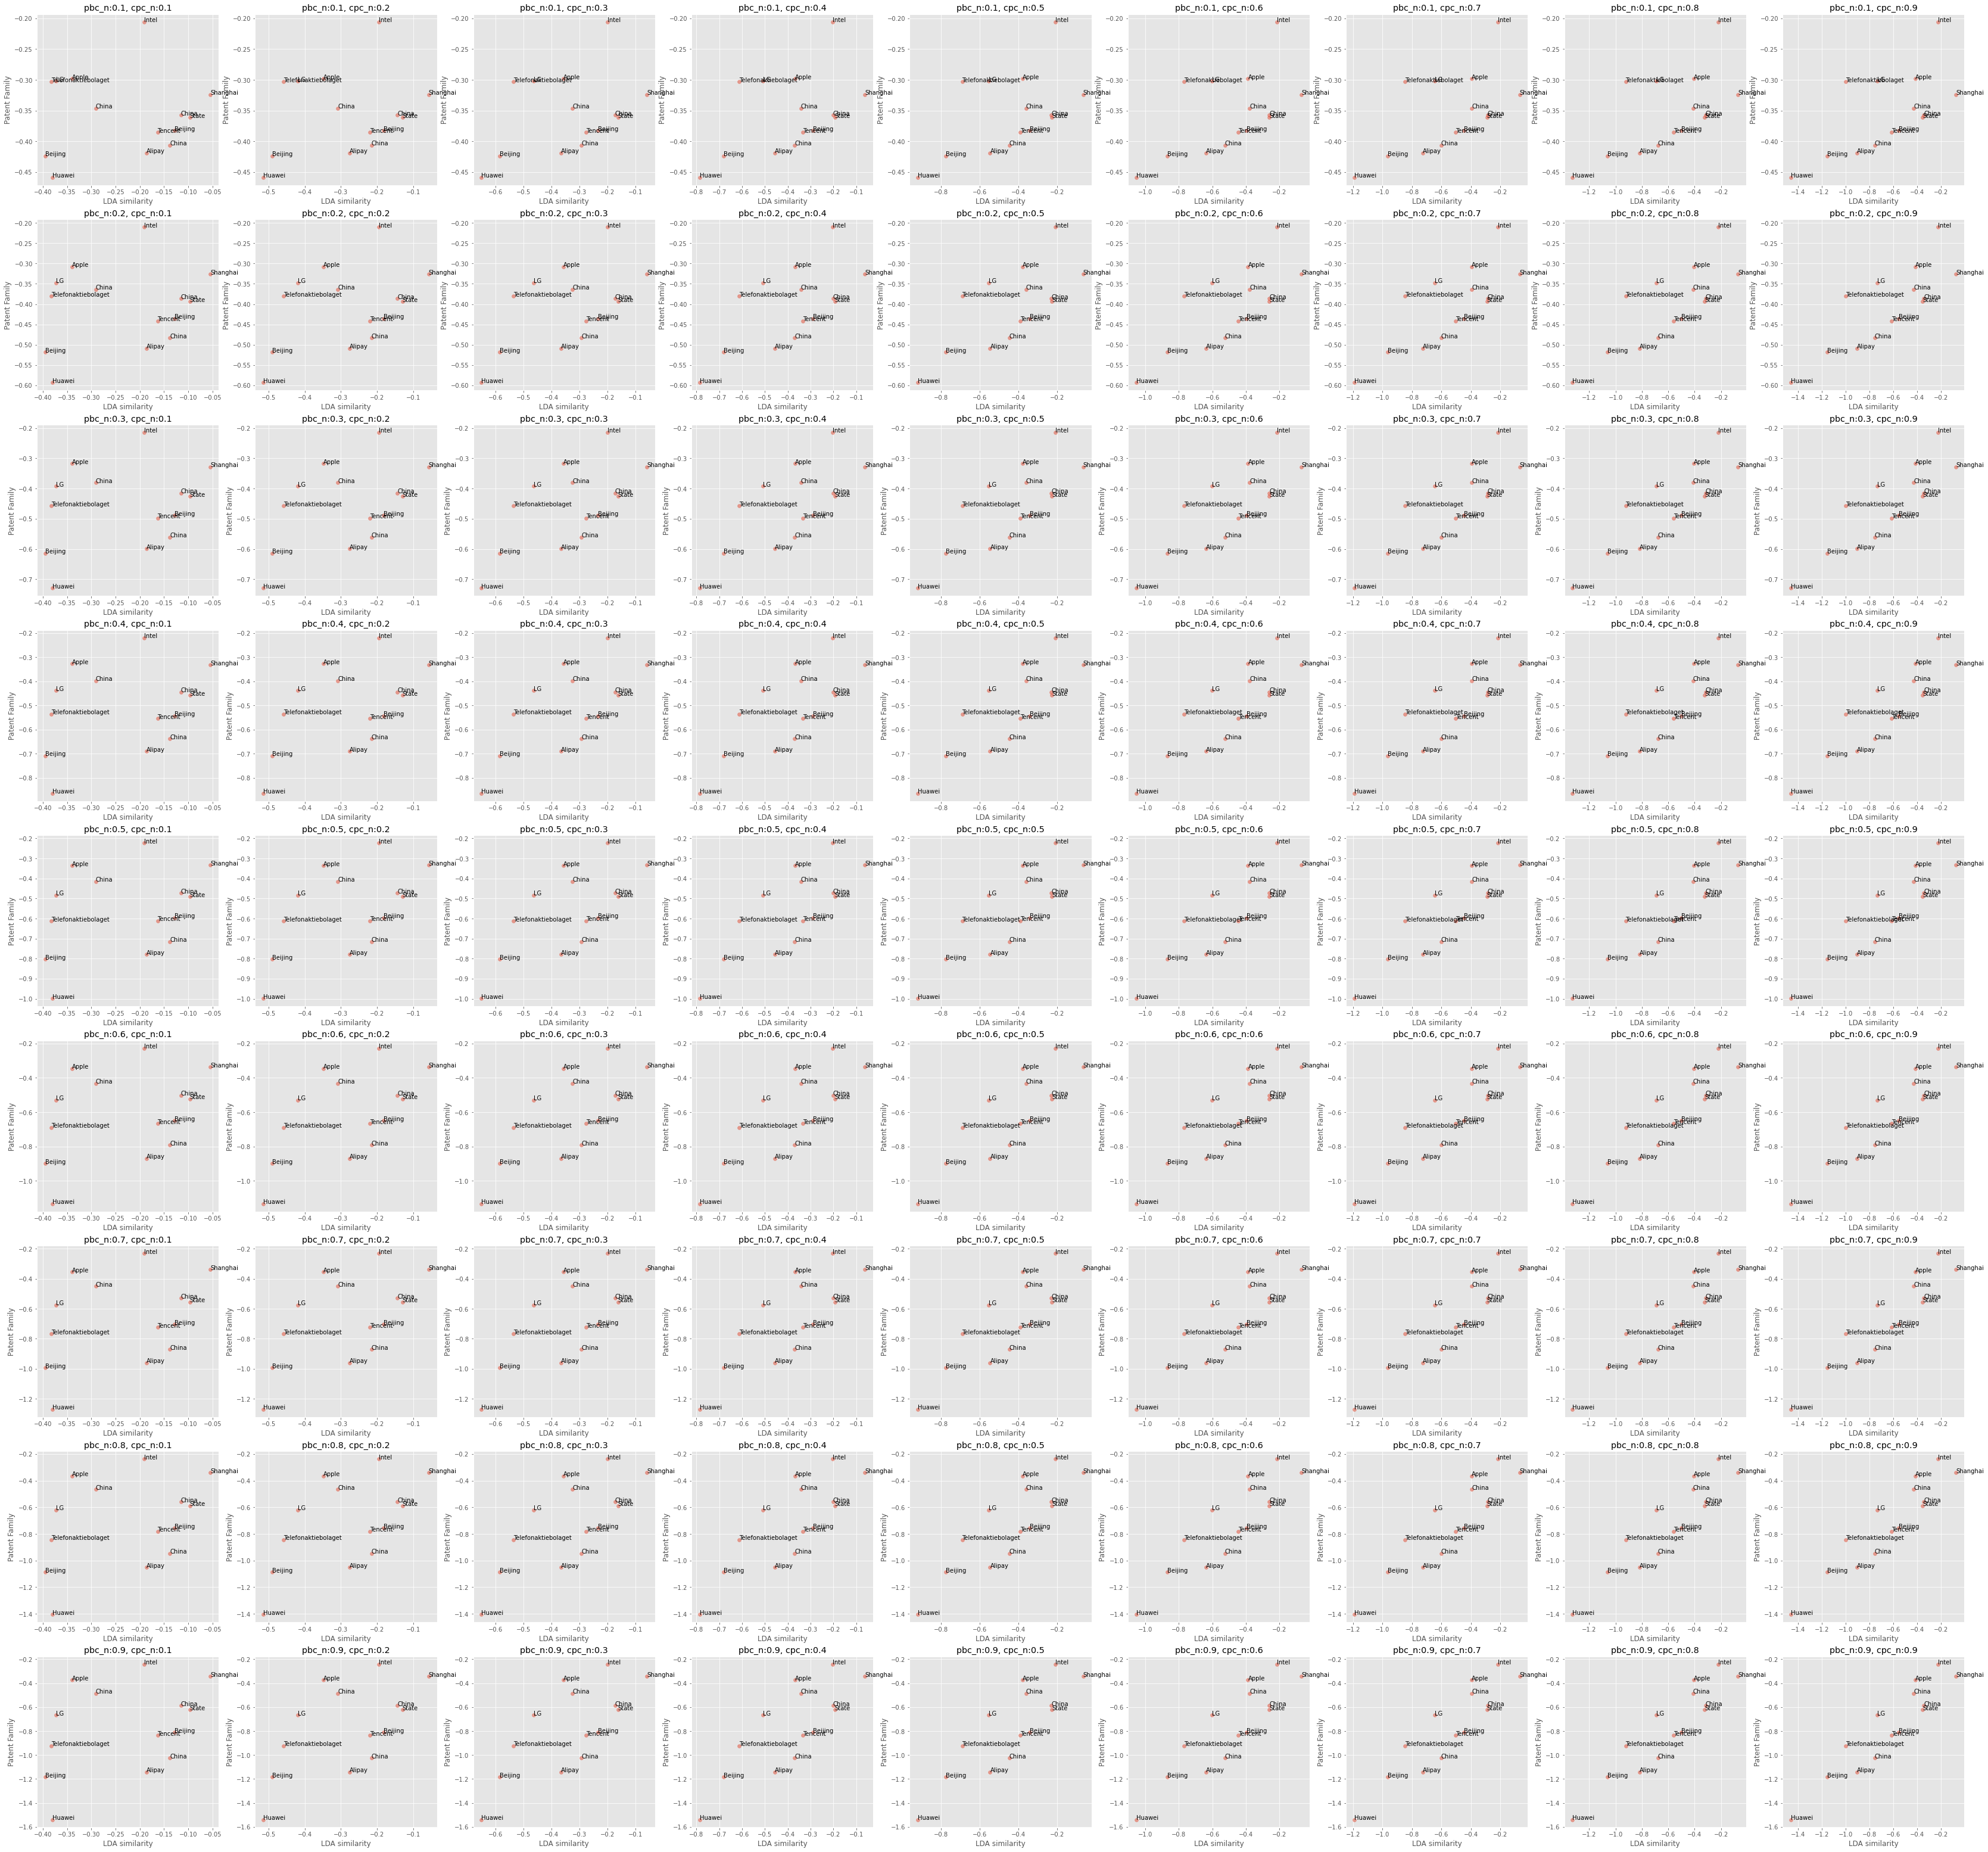

In [20]:
pbc_n_ls=np.arange(0.1,1,0.1)
cpc_n_ls=np.arange(0.1,1,0.1)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("LDA similarity")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_cn_brief_2020_1.png'.format(pbc_n))

In [21]:
c_df

,cpc,country
company,,
Huawei Technologies Co Ltd,1.461120,1.539802
Apple Inc,0.414667,0.373590
Shanghai Langbo Communication Technology Co Ltd,0.074179,0.343405
Intel Corp,0.226381,0.240767
China United Network Communications Group Co Ltd,0.428815,0.483765
China Mobile Communications Group Co Ltd,0.345136,0.587665
State Grid Corp of China SGCC,0.356262,0.620286
LG Electronics Inc,0.737143,0.665837
Beijing Sankuai Online Technology Co Ltd,0.556094,0.810537


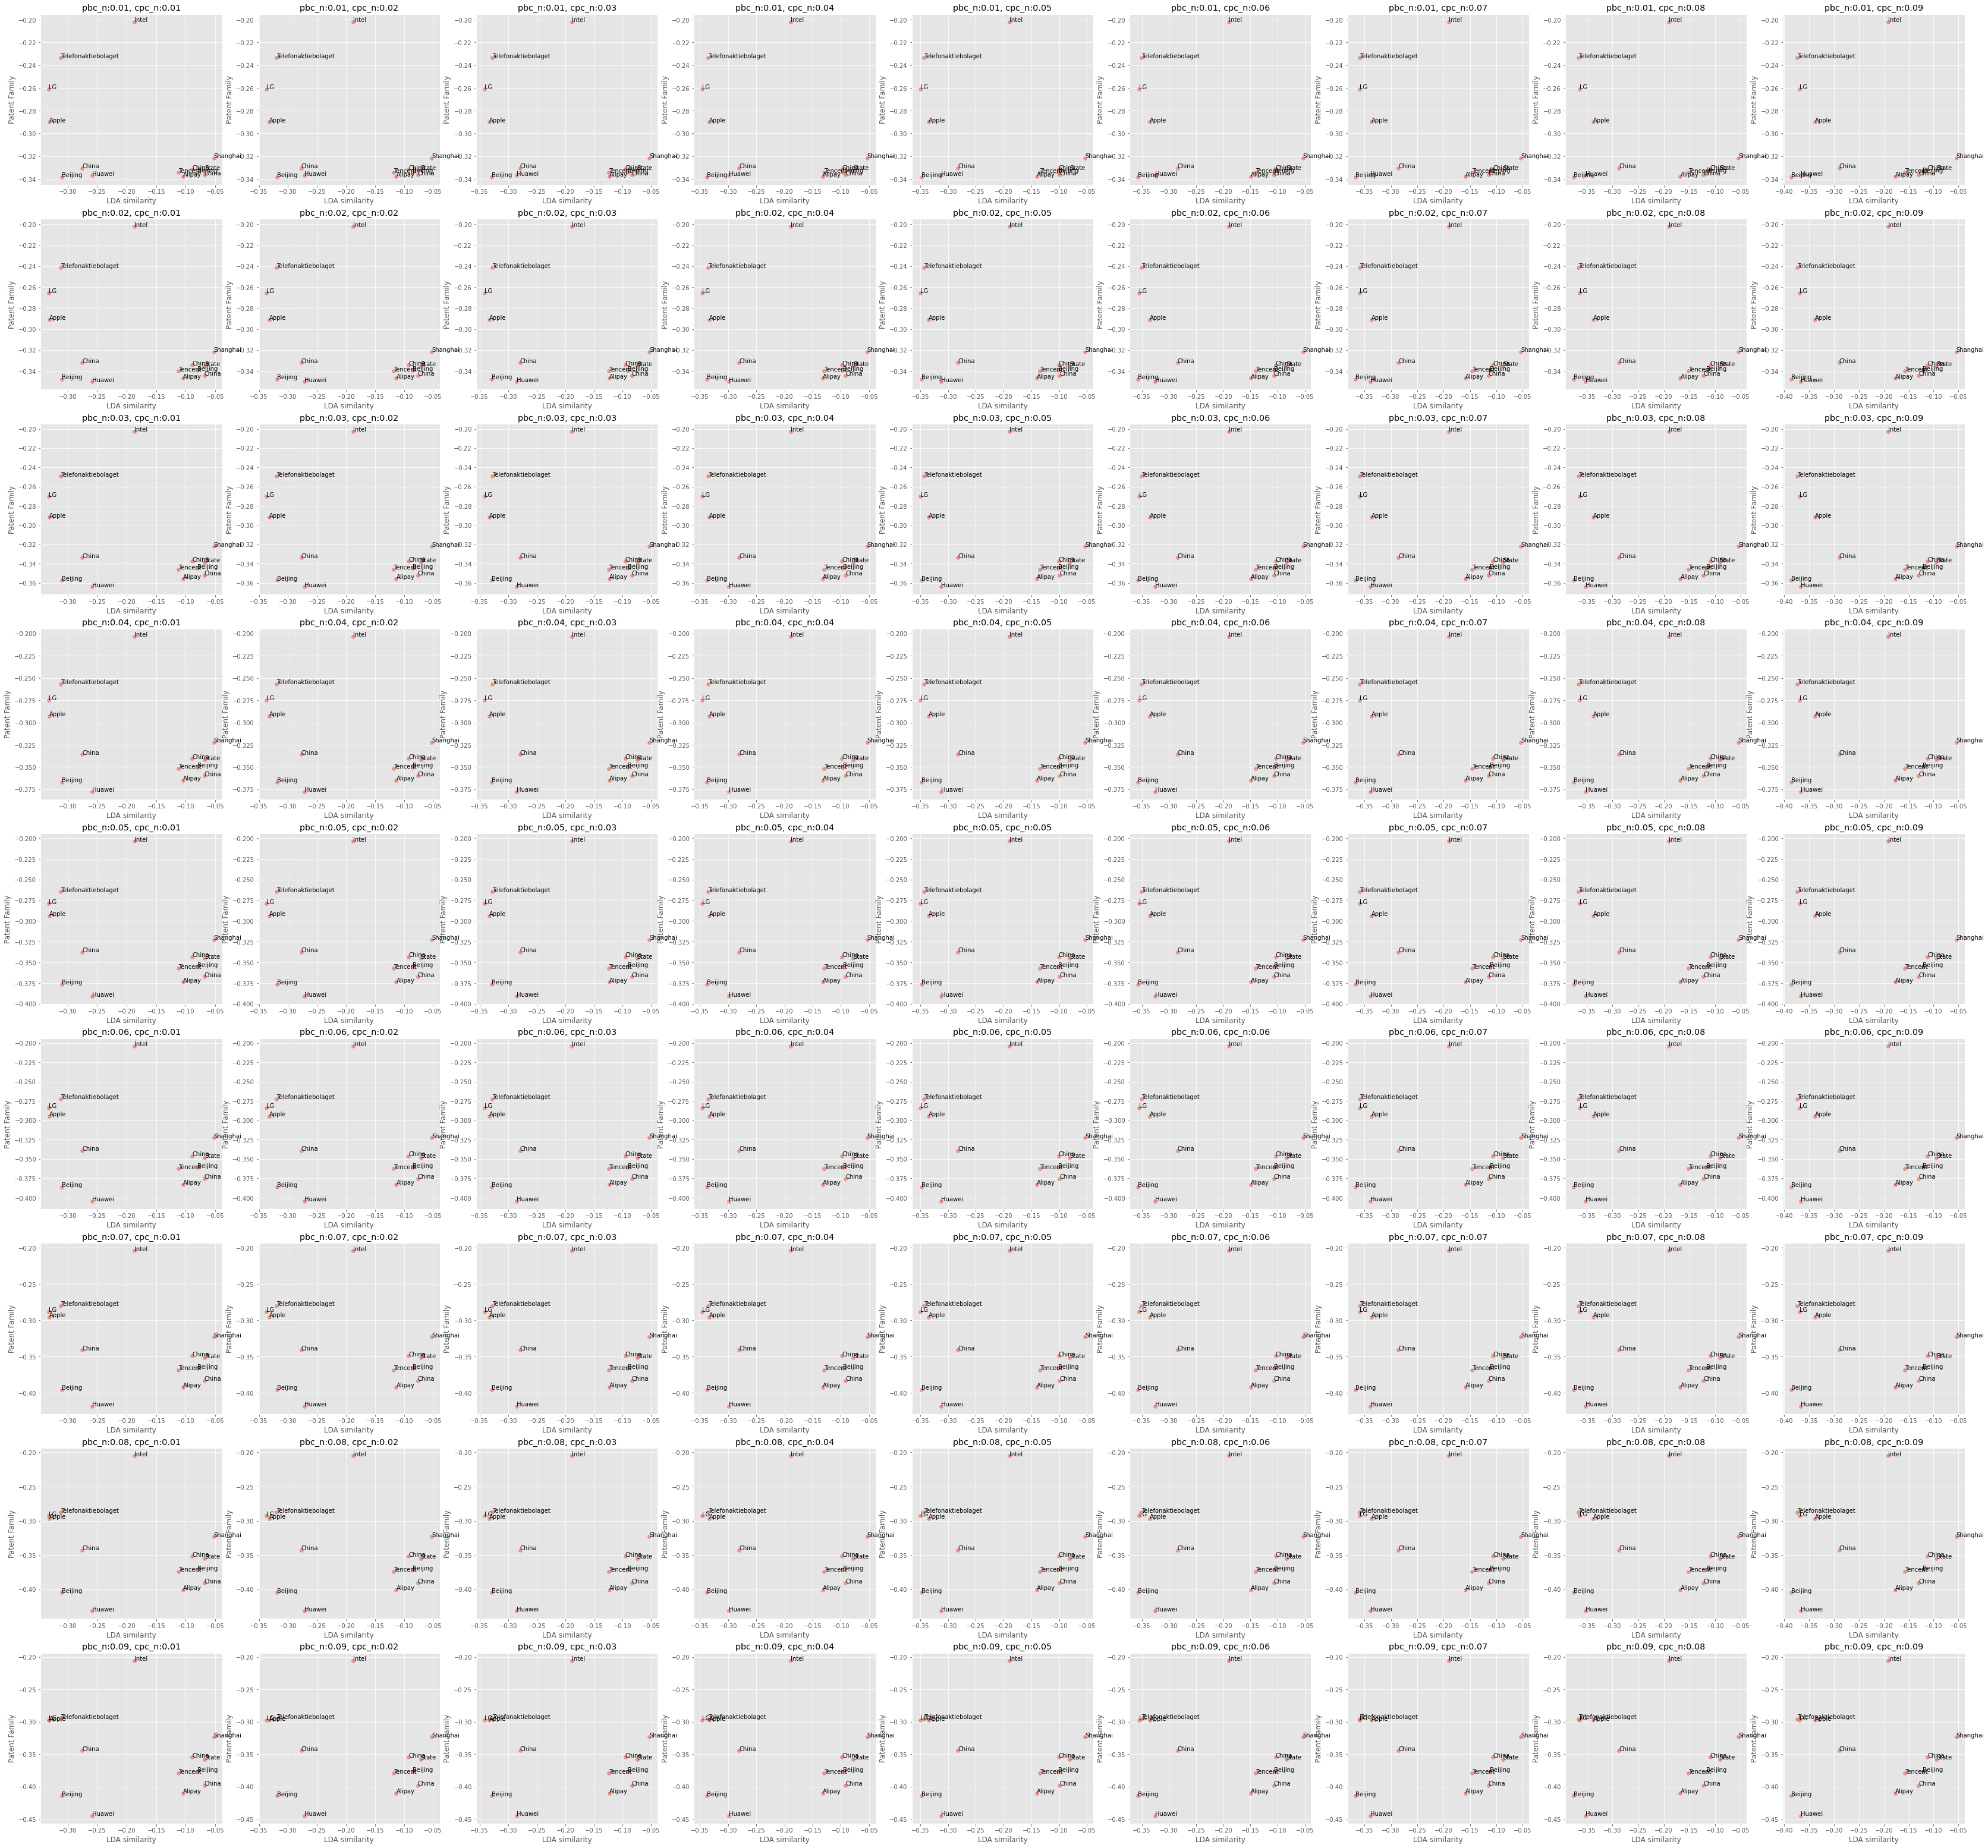

In [22]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("LDA similarity")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_cn_brief_2020_2.png'.format(pbc_n))

In [23]:
c_df

,cpc,country
company,,
Huawei Technologies Co Ltd,0.366366,0.445048
Apple Inc,0.338637,0.297559
Shanghai Langbo Communication Technology Co Ltd,0.054253,0.323479
Intel Corp,0.190969,0.205354
China United Network Communications Group Co Ltd,0.289351,0.344300
China Mobile Communications Group Co Ltd,0.112161,0.354690
State Grid Corp of China SGCC,0.093928,0.357953
LG Electronics Inc,0.368683,0.297376
Beijing Sankuai Online Technology Co Ltd,0.122535,0.376978


In [24]:
c_df = scatter_plot(pbc_n,cpc_n)
c_df = c_df.reset_index()
c_df["company"] = c_df.company.apply(lambda x: x.replace(" Inc","")\
                                                    .replace(" Co Ltd","")\
                                                    .replace(" Co. Ltd.","")\
                                                    .replace(" Co., Ltd.","")\
                                                    .replace(" Ltd","")\
                                                    .replace(" Corp","")\
                                                    .replace("..","")\
                                                    .replace("International Business Machines","IBM")\
                                                    .replace("Nippon Telegraph and Telephone","Nippon Telegraph & Tel")\
                                                    .replace("Alibaba Group Holding Ltd","Alibaba")\
                                                    .replace("ZTE Intelligent IoT Technology","ZTE")\
                                                    .replace("AT&T Intellectual Property I LP","AT&T")\
                                                    .replace("Microsoft Technology Licensing LLC","Microsoft")\
                                                    .replace("Telefonaktiebolaget LM Ericsson AB","Ericsson")\
                                                    .replace("Cisco Technology","Cisco Systems")\
                                                    .replace("Verizon Patent and Licensing","Verizon Communications")\
                                                    .replace("Nokia Technologies Oy","Nokia")\
                                                    .replace("China Mobile Communications Group","China Mobile")\
                                                    .replace("Nokia Solutions and Networks Oy","Nokia")\
                                                    .replace("China Mobile IoT","China_Mobile_IoT")\
                                                    .replace("China Mobile","China_Mobile")\
                                                    .replace("China United Network Communications Group","China_Unicom")\
                                                    .replace("Shanghai Langbo Communication Technology","Shanghai_Langbo")\
                                                    .replace("State Grid of China SGCC","SGCC")\
                                                    .replace("Beijing Sankuai Online Technology","Beijing_Sankuai")\
                                                    .replace("Beijing Xiaomi Mobile Software","Xiaomi"))
c_df.set_index("company", inplace=True)
c_df = c_df.drop("Samsung Electronics")

In [25]:
c_df

,cpc,country
company,,
Huawei Technologies,0.366366,0.445048
Apple,0.338637,0.297559
Shanghai_Langbo,0.054253,0.323479
Intel,0.190969,0.205354
China_Unicom,0.289351,0.344300
China_Mobile,0.112161,0.354690
SGCC,0.093928,0.357953
LG Electronics,0.368683,0.297376
Beijing_Sankuai,0.122535,0.376978


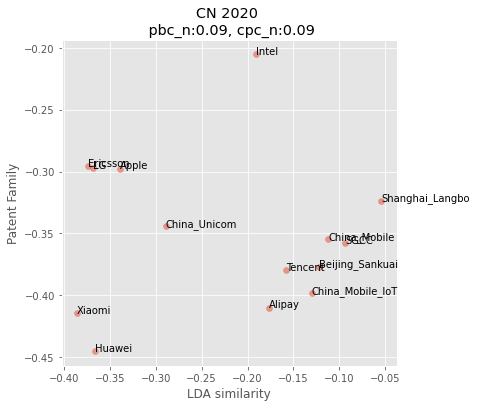

In [26]:
pbc_n=0.09
cpc_n=0.09
# c_df = scatter_plot(pbc_n,cpc_n)
# c_df = c_df.drop("Samsung Electronics Co Ltd")

plt.figure(figsize=(6,6))
plt.style.use('ggplot')
#plot
# plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.title("CN 2020 \n pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
plt.xlabel("LDA similarity")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

In [27]:
m_x = (-max(c_df.cpc)-min(c_df.cpc))/2
m_y = (-max(c_df.country)-min(c_df.country))/2

competitor_ls = []

for i,cpc,con in zip(c_df.index,c_df["cpc"],c_df["country"]):
    if -cpc>m_x and -con>m_y:
        competitor_ls.append(1)
    elif -cpc<m_x and -con>m_y:
        competitor_ls.append(2)
    elif -cpc>m_x and -con<m_y:
        competitor_ls.append(3)
    else:
        competitor_ls.append(4)

In [28]:
competitor_ls

[4, 2, 1, 1, 4, 3, 3, 2, 3, 3, 3, 2, 3, 4]

In [29]:
c_df

,cpc,country
company,,
Huawei Technologies,0.366366,0.445048
Apple,0.338637,0.297559
Shanghai_Langbo,0.054253,0.323479
Intel,0.190969,0.205354
China_Unicom,0.289351,0.344300
China_Mobile,0.112161,0.354690
SGCC,0.093928,0.357953
LG Electronics,0.368683,0.297376
Beijing_Sankuai,0.122535,0.376978


In [30]:
c_df.to_csv("competitor_df/company/lda_cn_2020.csv")